Fitting 5 folds for each of 8 candidates, totalling 40 fits

Melhores parâmetros: {'classifier__max_depth': None, 'classifier__min_samples_split': 5, 'classifier__n_estimators': 200}
Acurácia: 74.85%

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.65      0.83      0.72       530
           1       0.86      0.70      0.77       794

    accuracy                           0.75      1324
   macro avg       0.75      0.76      0.75      1324
weighted avg       0.77      0.75      0.75      1324



<Figure size 800x600 with 0 Axes>

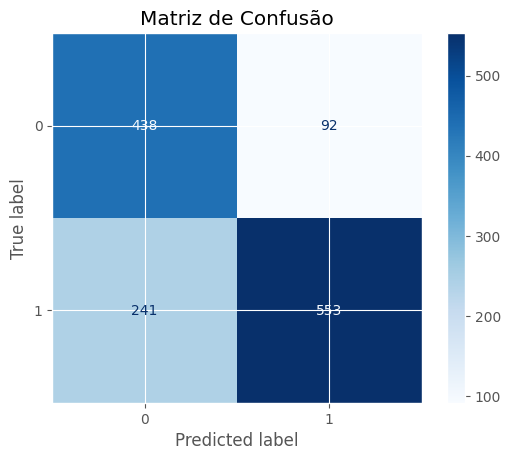

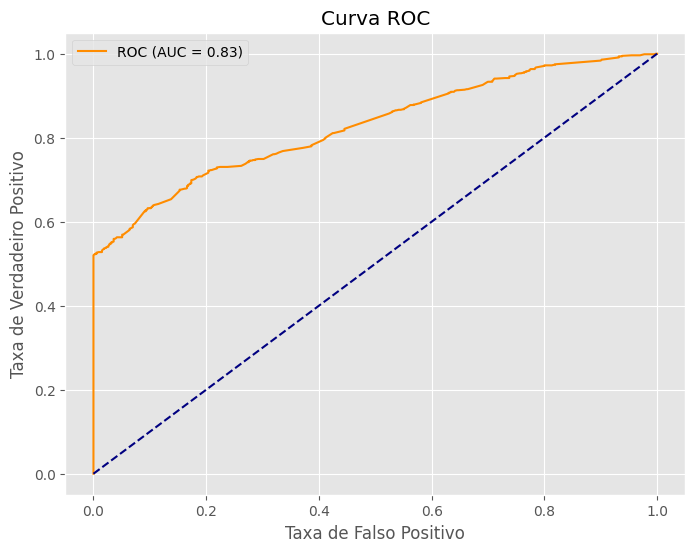

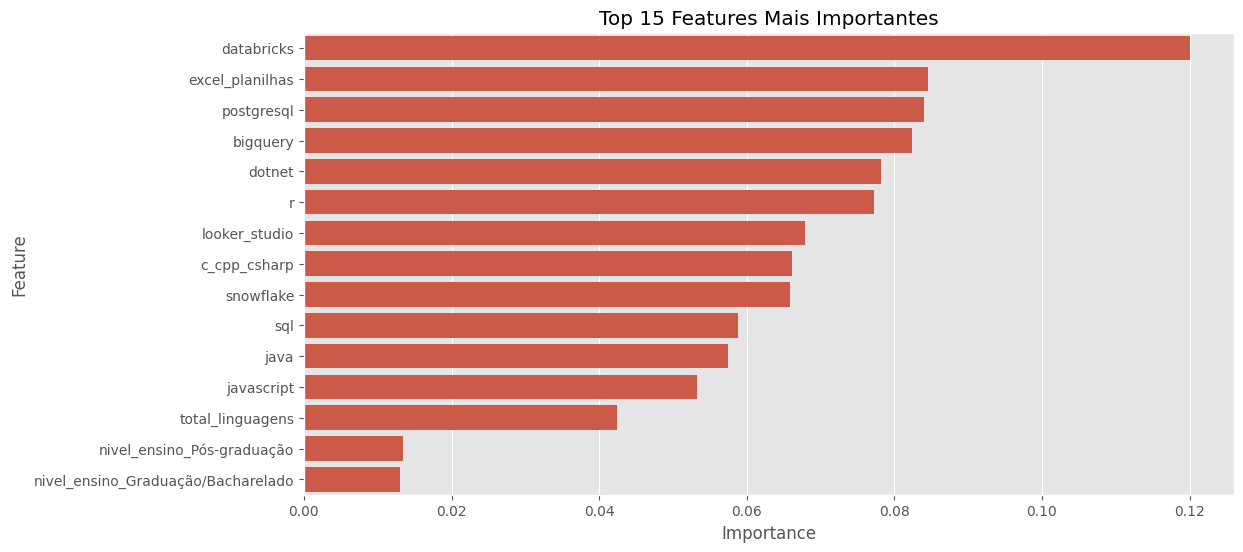

In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (accuracy_score, confusion_matrix, ConfusionMatrixDisplay,
                             classification_report, roc_curve, auc)
import matplotlib.pyplot as plt
import seaborn as sns

# Configurações iniciais
pd.set_option('display.max_columns', 50)
plt.style.use('ggplot')

# 1. Carregar e preparar os dados
df = pd.read_csv('dados_selecionados.csv')

# Criar variável target
tech_cols = ['python', 'aws', 'azure', 'gcp', 'powerbi', 'tableau']
df[tech_cols] = df[tech_cols].astype(bool)

conditions = (
    df['python'] &
    (df['aws'] | df['azure'] | df['gcp']) &
    (df['powerbi'] | df['tableau'])
)
df['target_ia_generativa'] = np.where(conditions, 1, 0)

# 2. Remover features que causam vazamento
features_seguras = [
    'sql', 'r', 'c_cpp_csharp', 'dotnet', 'java', 'javascript',
    'postgresql', 'bigquery', 'snowflake', 'databricks',
    'looker_studio', 'excel_planilhas', 'exp_dados', 'exp_ti'
]

# 3. Engenharia de features alternativa
df['total_linguagens'] = df[['sql', 'r', 'c_cpp_csharp', 'java', 'javascript']].sum(axis=1)
df['exp_total'] = df['exp_dados'] + df['exp_ti']
features_seguras.extend(['total_linguagens', 'exp_total'])

# 4. Pré-processamento Corrigido
# Converter colunas categóricas para numéricas
for col in features_seguras:
    if df[col].dtype == 'object':
        df[col] = df[col].map({'Sim': 1, 'Não': 0}).fillna(0).astype(int)

# Mapeamento de experiência
exp_map = {
    'Menos de 1 ano': 0.5,
    'de 1 a 2 anos': 1.5,
    'de 3 a 4 anos': 3.5,
    'de 5 a 6 anos': 5.5,
    'de 7 a 10 anos': 8.5,
    'Mais de 10 anos': 11
}

df['exp_dados'] = df['exp_dados'].astype(str).map(exp_map).fillna(0)
df['exp_ti'] = df['exp_ti'].astype(str).map(exp_map).fillna(0)

# Definir features numéricas
numeric_features = [
    'sql', 'r', 'c_cpp_csharp', 'dotnet', 'java', 'javascript',
    'postgresql', 'bigquery', 'snowflake', 'databricks',
    'looker_studio', 'excel_planilhas', 'exp_dados', 'exp_ti',
    'total_linguagens', 'exp_total'
]

# Pipeline de pré-processamento
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), ['nivel_ensino']),
        ('num', StandardScaler(), numeric_features)
    ],
    remainder='drop'
)

# 5. Modelagem
X = df[features_seguras + ['nivel_ensino']]
y = df['target_ia_generativa']

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.25,
    stratify=y,
    random_state=42
)

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(
        class_weight='balanced_subsample',
        random_state=42,
        n_jobs=-1
    ))
])

params = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [None, 10],
    'classifier__min_samples_split': [2, 5]
}

grid_search = GridSearchCV(
    pipeline,
    params,
    cv=5,
    scoring='f1',
    verbose=1,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

# 6. Avaliação
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1]

print("\nMelhores parâmetros:", grid_search.best_params_)
print(f"Acurácia: {accuracy_score(y_test, y_pred):.2%}")
print("\nRelatório de Classificação:")
print(classification_report(y_test, y_pred))

# Matriz de Confusão
plt.figure(figsize=(8,6))
ConfusionMatrixDisplay.from_estimator(best_model, X_test, y_test, cmap='Blues')
plt.title('Matriz de Confusão')
plt.show()

# Curva ROC
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='darkorange', label=f'ROC (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('Taxa de Falso Positivo')
plt.ylabel('Taxa de Verdadeiro Positivo')
plt.title('Curva ROC')
plt.legend()
plt.show()

# 7. Análise de Features
feature_names = (
    list(grid_search.best_estimator_.named_steps['preprocessor']
        .named_transformers_['cat']
        .get_feature_names_out(['nivel_ensino'])) +
    numeric_features
)

importances = best_model.named_steps['classifier'].feature_importances_

feature_importances = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values('Importance', ascending=False)

plt.figure(figsize=(12,6))
sns.barplot(x='Importance', y='Feature', data=feature_importances.head(15))
plt.title('Top 15 Features Mais Importantes')
plt.show()